# This dataset contains 31,833 images from HaGRID (HAnd Gesture Recognition Image Dataset) downscaled to 384p. The dataset contains images of hand gestures.

In [17]:
!git clone https://huggingface.co/datasets/cj-mills/hagrid-sample-30k-384p

/bin/bash: /home/cvcluster3/miniconda3/envs/yolo_env/lib/libtinfo.so.6: no version information available (required by /bin/bash)
Клонирование в «hagrid-sample-30k-384p»...
remote: Enumerating objects: 16, done.
remote: Total 16 (delta 0), reused 0 (delta 0), pack-reused 16
Распаковка объектов: 100% (16/16), 2.72 КиБ | 557.00 КиБ/с, готово.


In [2]:
!mkdir funny_people_dataset && cd "$_"
!mkdir images labels
!mkdir images/train images/val && cd ..
!mkdir labels/train labels/val

/bin/bash: /home/cvcluster3/miniconda3/envs/yolo_env/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/bin/bash: /home/cvcluster3/miniconda3/envs/yolo_env/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/bin/bash: /home/cvcluster3/miniconda3/envs/yolo_env/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/bin/bash: /home/cvcluster3/miniconda3/envs/yolo_env/lib/libtinfo.so.6: no version information available (required by /bin/bash)


In [9]:
!cd ./hagrid-sample-30k-384p

/bin/bash: /home/cvcluster3/miniconda3/envs/yolo_env/lib/libtinfo.so.6: no version information available (required by /bin/bash)


In [ ]:
!sudo apt install unzip
!unzip hagrid-sample-30k-384p.zip

In [15]:
!pwd

/bin/bash: /home/cvcluster3/miniconda3/envs/yolo_env/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/home/cvcluster3/Рабочий стол/DIMA_ML/dvfu_tasks/yolo-finetune


In [18]:
!unzip ./hagrid-sample-30k-384p/hagrid-sample-30k-384p.zip

/bin/bash: /home/cvcluster3/miniconda3/envs/yolo_env/lib/libtinfo.so.6: no version information available (required by /bin/bash)
Archive:  ./hagrid-sample-30k-384p/hagrid-sample-30k-384p.zip
 extracting: hagrid-sample-30k-384p/annotations_df.parquet  
   creating: hagrid-sample-30k-384p/ann_train_val/
 extracting: hagrid-sample-30k-384p/ann_train_val/call.json  
 extracting: hagrid-sample-30k-384p/ann_train_val/dislike.json  
 extracting: hagrid-sample-30k-384p/ann_train_val/fist.json  
 extracting: hagrid-sample-30k-384p/ann_train_val/four.json  
 extracting: hagrid-sample-30k-384p/ann_train_val/like.json  
 extracting: hagrid-sample-30k-384p/ann_train_val/mute.json  
 extracting: hagrid-sample-30k-384p/ann_train_val/ok.json  
 extracting: hagrid-sample-30k-384p/ann_train_val/one.json  
 extracting: hagrid-sample-30k-384p/ann_train_val/palm.json  
 extracting: hagrid-sample-30k-384p/ann_train_val/peace.json  
 extracting: hagrid-sample-30k-384p/ann_train_val/peace_inverted.json  
 ext

In [1]:
import os
import cv2
import torch
import random
import ultralytics
import numpy as np
import pandas as pd
import sklearn.model_selection
import matplotlib.colors as mcolors

from ultralytics import YOLO
from matplotlib import pyplot as plt

mcolors.BASE_COLORS.pop('w')

(1, 1, 1)

In [2]:
torch.cuda.is_available()

True

In [5]:
classes = [
    'call',
    'no_gesture',
    'dislike',
    'fist',
    'four',
    'like',
    'mute',
    'ok',
    'one',
    'palm',
    'peace',
    'peace_inverted',
    'rock',
    'stop',
    'stop_inverted',
    'three',
    'three2',
    'two_up',
    'two_up_inverted'
    ]

In [6]:
class_to_id = {class_name: id for id, class_name in enumerate(classes)}
class_to_id

{'call': 0,
 'no_gesture': 1,
 'dislike': 2,
 'fist': 3,
 'four': 4,
 'like': 5,
 'mute': 6,
 'ok': 7,
 'one': 8,
 'palm': 9,
 'peace': 10,
 'peace_inverted': 11,
 'rock': 12,
 'stop': 13,
 'stop_inverted': 14,
 'three': 15,
 'three2': 16,
 'two_up': 17,
 'two_up_inverted': 18}

In [10]:
data = pd.read_parquet('./hagrid-sample-30k-384p/annotations_df.parquet').drop(['leading_hand', 'leading_conf', 'user_id'], axis=1)

In [11]:
data

bboxes  \
00005c9c-3548-4a8f-9d0b-2dd4aff37fc9  [[0.23925175, 0.28595301, 0.25055143, 0.207776...   
0020a3db-82d8-47aa-8642-2715d4744db5  [[0.5801012999999999, 0.53265105, 0.14562138, ...   
004ac93f-0f7c-49a4-aadc-737e0ad4273c  [[0.46294793, 0.26419774, 0.13834939000000002,...   
006cac69-d3f0-47f9-aac9-38702d038ef1  [[0.38799208, 0.44643898, 0.27068787, 0.182778...   
00973fac-440e-4a56-b60c-2a06d5fb155d  [[0.40980118, 0.38144198, 0.08338464, 0.062297...   
...                                                                                 ...   
f4fd00a3-1f1e-4594-be3f-362229e430e1  [[0.46801204, 0.37731512, 0.20508805, 0.200085...   
f7308b1f-0433-42c3-b388-08e0ab2a84a7  [[0.30225301, 0.22838633, 0.12823989, 0.180910...   
f9103c94-a36e-44ea-acf4-f8ff36d4a2bf  [[0.19668888, 0.42850023, 0.1132281, 0.1760887...   
faf1d2ff-f273-47b2-a76b-30bc296703cd  [[0.49250894, 0.54393085, 0.05427064, 0.090299...   
fd1bf83f-d524-46f7-af88-fd448864e59e  [[0.31015179, 0.23072395, 0.09140199, 0.162342...   

                                                             labels  
00005c9c-3548-4a8f-9d0b-2dd4aff37fc9                         [call]  
0020a3db-82d8-47aa-8642-2715d4744db5                         [call]  
004ac93f-0f7c-49a4-aadc-737e0ad4273c                         [call]  
006cac69-d3f0-47f9-aac9-38702d038ef1                         [call]  
00973fac-440e-4a56-b60c-2a06d5fb155d             [call, no_gesture]  
...                                                             ...  
f4fd00a3-1f1e-4594-be3f-362229e430e1              [two_up_inverted]  
f7308b1f-0433-42c3-b388-08e0ab2a84a7              [two_up_inverted]  
f9103c94-a36e-44ea-acf4-f8ff36d4a2bf  [two_up_inverted, no_gesture]  
faf1d2ff-f273-47b2-a76b-30bc296703cd  [two_up_inverted, no_gesture]  
fd1bf83f-d524-46f7-af88-fd448864e59e  [two_up_inverted, no_gesture]  

[31833 rows x 2 columns]

In [15]:
root_path = './hagrid-sample-30k-384p/hagrid_30k/'
distination = './funny_people_dataset/images/'

In [13]:
def pd_from_path(directory: str) -> pd.DataFrame:
    data = []
    for path, _, files in os.walk(directory):
        for file in files:
            if file.endswith(('.jpg', '.png', '.jpeg')):
                data.append((f'{path}/{file}', file))

    return pd.DataFrame(data, columns=['imagepath', 'filename'])

In [16]:
train_images, val_images = sklearn.model_selection.train_test_split(pd_from_path(root_path), test_size=0.05, train_size=0.95, shuffle=True)

In [17]:
def move_img(df: pd.DataFrame, distination: str, split: str):
    for _, row in df.iterrows():
        os.rename(row.imagepath, f'{distination}{split}/{row.filename}')

In [18]:
move_img(train_images, distination, 'train')
move_img(val_images, distination, 'val')

In [19]:
train_images

imagepath  \
13459  ./hagrid-sample-30k-384p/hagrid_30k/train_val_...   
23390  ./hagrid-sample-30k-384p/hagrid_30k/train_val_...   
17142  ./hagrid-sample-30k-384p/hagrid_30k/train_val_...   
24279  ./hagrid-sample-30k-384p/hagrid_30k/train_val_...   
20715  ./hagrid-sample-30k-384p/hagrid_30k/train_val_...   
...                                                  ...   
1391   ./hagrid-sample-30k-384p/hagrid_30k/train_val_...   
21327  ./hagrid-sample-30k-384p/hagrid_30k/train_val_...   
8750   ./hagrid-sample-30k-384p/hagrid_30k/train_val_...   
16081  ./hagrid-sample-30k-384p/hagrid_30k/train_val_...   
30089  ./hagrid-sample-30k-384p/hagrid_30k/train_val_...   

                                       filename  
13459  bdf359ae-215b-4512-bf44-6885e77cbe16.jpg  
23390  bcc45577-5b27-4c38-8219-bee834d7b4eb.jpg  
17142  524eb18e-bcac-4670-a927-d330ff7d0580.jpg  
24279  1e6254b2-6ce1-4f51-90ad-d0e15dec41bb.jpg  
20715  52bbdfa4-3ebe-44cd-bd78-8002224f478b.jpg  
...                                         ...  
1391   b08ee3b8-26b2-49ed-9713-6d81b11bcc89.jpg  
21327  bea9c362-0e79-4ae6-86b1-d8678d946c50.jpg  
8750   e6e1d38b-c39c-4cf1-bfb9-d419a1f46e62.jpg  
16081  c24e9efc-d36c-409a-a6d7-0241a73425fd.jpg  
30089  65c81447-6f7b-474d-8057-b7d1cd98285a.jpg  

[30241 rows x 2 columns]

In [20]:
labels_path = './funny_people_dataset/labels'

def get_image_description(stplitted_data: pd.DataFrame, data: pd.DataFrame, labels_root_path: str, split: str):
    for _, row in stplitted_data.iterrows():
        image_name = row.filename.replace('.jpg', '')
        with open(f'{labels_root_path}/{split}/{image_name}.txt', 'w+') as bboxes_discription:
            image = data.loc[image_name]
            for bboxes_amount in range(len(image.labels)):
                top_left_x_point, top_left_y_point, width, height = image.bboxes[bboxes_amount]
                x_center, y_center = top_left_x_point + width / 2, top_left_y_point + height / 2
                bbox_str = f'{class_to_id[image.labels[bboxes_amount]]} {x_center} {y_center} {width} {height}'
                print(bbox_str, file=bboxes_discription)
            bboxes_discription.close()

In [21]:
get_image_description(train_images, data, labels_path, 'train')
get_image_description(val_images, data, labels_path, 'val')

In [22]:
model = YOLO('yolov8m.pt')

100%|██████████| 49.7M/49.7M [00:45<00:00, 1.14MB/s]


In [25]:
results = model.train(
    data='funny_people.yaml',
    epochs=10,
    imgsz=800,
    name='yoloHYPE',
    save_period=2,
    device=0,
    workers=1,
    )

Ultralytics YOLOv8.1.27 🚀 Python-3.10.13 torch-2.2.1 CUDA:0 (NVIDIA GeForce RTX 3090, 24226MiB)
engine/trainer: task=detect, mode=train, model=yolov8m.pt, data=funny_people.yaml, epochs=10, time=None, patience=100, batch=16, imgsz=800, save=True, save_period=2, cache=False, device=0, workers=8, project=None, name=yoloHYPE2, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_

2024-03-31 10:40:37.626220: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Overriding model.yaml nc=80 with nc=19

                   from  n    params  module                                       arguments                     
  0                  -1  1      1392  ultralytics.nn.modules.conv.Conv             [3, 48, 3, 2]                 
  1                  -1  1     41664  ultralytics.nn.modules.conv.Conv             [48, 96, 3, 2]                
  2                  -1  2    111360  ultralytics.nn.modules.block.C2f             [96, 96, 2, True]             
  3                  -1  1    166272  ultralytics.nn.modules.conv.Conv             [96, 192, 3, 2]               
  4                  -1  4    813312  ultralytics.nn.modules.block.C2f             [192, 192, 4, True]           
  5                  -1  1    664320  ultralytics.nn.modules.conv.Conv             [192, 384, 3, 2]              
  6                  -1  4   3248640  ultralytics.nn.modules.block.C2f             [384, 384, 4, True]           
  7                  -1  1   1991808  ultralytic

100%|██████████| 6.23M/6.23M [00:03<00:00, 2.17MB/s]


AMP: checks passed ✅


train: Scanning /home/cvcluster3/YOLO_train/datasets/funny_people_dataset/labels/train... 30241 images, 0 backgrounds, 0 corrupt: 100%|██████████| 30241/30241 [00:28<00:00, 1056.23it/s]


train: New cache created: /home/cvcluster3/YOLO_train/datasets/funny_people_dataset/labels/train.cache


val: Scanning /home/cvcluster3/YOLO_train/datasets/funny_people_dataset/labels/val... 1592 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1592/1592 [00:01<00:00, 989.52it/s] 

val: New cache created: /home/cvcluster3/YOLO_train/datasets/funny_people_dataset/labels/val.cache


Plotting labels to runs/detect/yoloHYPE2/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000435, momentum=0.9) with parameter groups 77 weight(decay=0.0), 84 weight(decay=0.0005), 83 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 800 train, 800 val
Using 8 dataloader workers
Logging results to runs/detect/yoloHYPE2
Starting training for 10 epochs...
Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/10      10.7G     0.7916      1.362       1.05          1        800: 100%|██████████| 1891/1891 [09:31<00:00,  3.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:10<00:00,  4.89it/s]

                   all       1592       1946      0.957      0.928      0.973      0.807



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/10      10.9G     0.7421      0.581      1.019          1        800: 100%|██████████| 1891/1891 [09:18<00:00,  3.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:09<00:00,  5.13it/s]

                   all       1592       1946      0.948      0.947       0.98      0.822



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/10      10.9G       0.72      0.514      1.002          2        800: 100%|██████████| 1891/1891 [09:13<00:00,  3.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:09<00:00,  5.08it/s]

                   all       1592       1946      0.957      0.968      0.983      0.833



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/10      10.9G     0.6956     0.4567     0.9816          1        800: 100%|██████████| 1891/1891 [09:13<00:00,  3.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:09<00:00,  5.09it/s]

                   all       1592       1946      0.985      0.964      0.989      0.845



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/10      10.9G      0.678     0.4178     0.9722          1        800: 100%|██████████| 1891/1891 [09:10<00:00,  3.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:09<00:00,  5.07it/s]

                   all       1592       1946      0.976      0.968      0.987      0.851



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/10      10.9G      0.657      0.379     0.9577          1        800: 100%|██████████| 1891/1891 [09:11<00:00,  3.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:09<00:00,  5.05it/s]

                   all       1592       1946      0.984       0.98      0.991      0.862



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/10      10.9G     0.6353     0.3478     0.9434          1        800: 100%|██████████| 1891/1891 [09:14<00:00,  3.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:09<00:00,  5.05it/s]

                   all       1592       1946      0.988      0.984      0.993      0.866



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/10      10.9G     0.6184     0.3224     0.9367          1        800: 100%|██████████| 1891/1891 [09:13<00:00,  3.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:09<00:00,  5.02it/s]

                   all       1592       1946      0.989      0.986      0.993      0.877



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/10      10.9G     0.5991     0.2981     0.9201          2        800: 100%|██████████| 1891/1891 [09:13<00:00,  3.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:09<00:00,  5.07it/s]

                   all       1592       1946      0.991      0.982      0.993      0.882



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/10      10.9G     0.5832     0.2738     0.9133          1        800: 100%|██████████| 1891/1891 [08:48<00:00,  3.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:09<00:00,  5.12it/s]

                   all       1592       1946       0.99      0.988      0.993      0.883



10 epochs completed in 1.569 hours.
Optimizer stripped from runs/detect/yoloHYPE2/weights/last.pt, 52.0MB
Optimizer stripped from runs/detect/yoloHYPE2/weights/best.pt, 52.0MB

Validating runs/detect/yoloHYPE2/weights/best.pt...
Ultralytics YOLOv8.1.27 🚀 Python-3.10.13 torch-2.2.1 CUDA:0 (NVIDIA GeForce RTX 3090, 24226MiB)
Model summary (fused): 218 layers, 25850761 parameters, 0 gradients, 78.7 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:10<00:00,  4.88it/s]


                   all       1592       1946       0.99      0.988      0.992      0.883
                  call       1592         92      0.988          1      0.995      0.865
            no_gesture       1592        354      0.972       0.96      0.988       0.78
               dislike       1592         91          1      0.967       0.99      0.861
                  fist       1592         99      0.999          1      0.995       0.88
                  four       1592         85      0.972          1      0.995      0.905
                  like       1592         83          1      0.989      0.995      0.881
                  mute       1592        102      0.998          1      0.995      0.857
                    ok       1592         83      0.991          1      0.995      0.911
                   one       1592         93      0.966          1      0.985      0.895
                  palm       1592         78      0.986      0.974       0.99      0.919
                 peac

In [2]:
trained_model = YOLO('runs/detect/yoloHYPE2/weights/best.pt')

In [3]:
def images_from_path(directory: str) -> list:
    data = []
    for path, _, files in os.walk(directory):
        for file in files:
            if file.endswith(('.jpg', '.png', '.jpeg', '.bmp', '.gif')):
                data.append(f'{path}/{file}')

    return data

In [7]:
images = images_from_path('./test_images')
images

['./test_images/000ae427-e89a-418f-8085-a59750bda9d2.jpg',
 './test_images/000d695b-18fb-4613-b981-2500e951f88e.jpg',
 './test_images/000dce1c-2e26-44c6-9ff7-cac174db1359.jpg',
 './test_images/000dfde3-a3a2-41b3-a3eb-e52744bf3ac4.jpg',
 './test_images/000dfe2c-ffd0-4a3e-991f-9844d35ebbaf.jpg',
 './test_images/00a21d28-a152-49d1-bf5a-c22a81df75b7.jpg',
 './test_images/00a2f936-93f3-46ca-b448-987c8f6f76b7.jpg',
 './test_images/00a302e3-0091-45da-8b56-f05872dc1716.jpg',
 './test_images/00a5cee2-1a01-4c3b-9f47-e372c1b2d9dd.jpg',
 './test_images/00a6c250-88c5-4c1b-9713-0164e4a040ac.jpg',
 './test_images/danil_call.jpeg',
 './test_images/danil_ok.jpeg',
 './test_images/denis_call.jpeg',
 './test_images/dima_peace.jpeg',
 './test_images/maxim_call.jpeg']

In [68]:
def draw_results(
        results: list[ultralytics.engine.results.Results],
        orig_size: bool = False,
        axis: bool = True,
        image_size: tuple[int] = (500, 500)
        ):
    
    n_images = len(results)
    n_columns = 4
    n_rows = (n_images - 1) // n_columns + 1
    figsize = 15, (n_rows + 1) // 2 * 7.5
    figure = plt.figure(figsize=figsize)

    for i in range(1, n_images + 1):
        result = results[i - 1]
        image = cv2.cvtColor(result.orig_img, cv2.COLOR_BGR2RGB)
        if orig_size:
            image_size = result.orig_shape[1], result.orig_shape[0]
        image = cv2.resize(image, image_size)
        coef_x, coef_y = image_size[0] / result.orig_shape[1], image_size[1] / result.orig_shape[0]
        for bounding_box, cls in zip(result.boxes.xyxy, result.boxes.cls):
            x0, y0, x1, y1 = bounding_box
            x0, y0, x1, y1 = x0 * coef_x, y0 * coef_y, x1 * coef_x, y1 * coef_y
            
            start_point = (int(x0), int(y0))
            end_point = (int(x1), int(y1))
            box_color = tuple(int(i * 255) for i in random.choice(list(mcolors.BASE_COLORS.values())))
            cv2.rectangle(image, start_point, end_point, color=box_color, thickness=3)
            
            cv2.putText(
                image,
                result.names[int(cls)],
                (int(x0), int(y0) - 5),
                fontFace=cv2.FONT_HERSHEY_SIMPLEX,
                fontScale=1.2,
                color=(255, 165, 0),
                thickness=2,
            )
        figure.add_subplot(n_rows, n_columns, i)
        if not axis:
            plt.axis('off')
        plt.imshow(image)
    


0: 800x800 1 no_gesture, 1 three, 1: 800x800 1 call, 2: 800x800 1 peace_inverted, 3: 800x800 1 three2, 4: 800x800 1 stop, 5: 800x800 1 mute, 6: 800x800 1 fist, 7: 800x800 1 three, 8: 800x800 1 ok, 9: 800x800 1 peace, 10: 800x800 1 three2, 11: 800x800 1 call, 12: 800x800 1 no_gesture, 1 ok, 307.5ms
Speed: 15.2ms preprocess, 23.7ms inference, 0.9ms postprocess per image at shape (1, 3, 800, 800)


(15, 15.0)


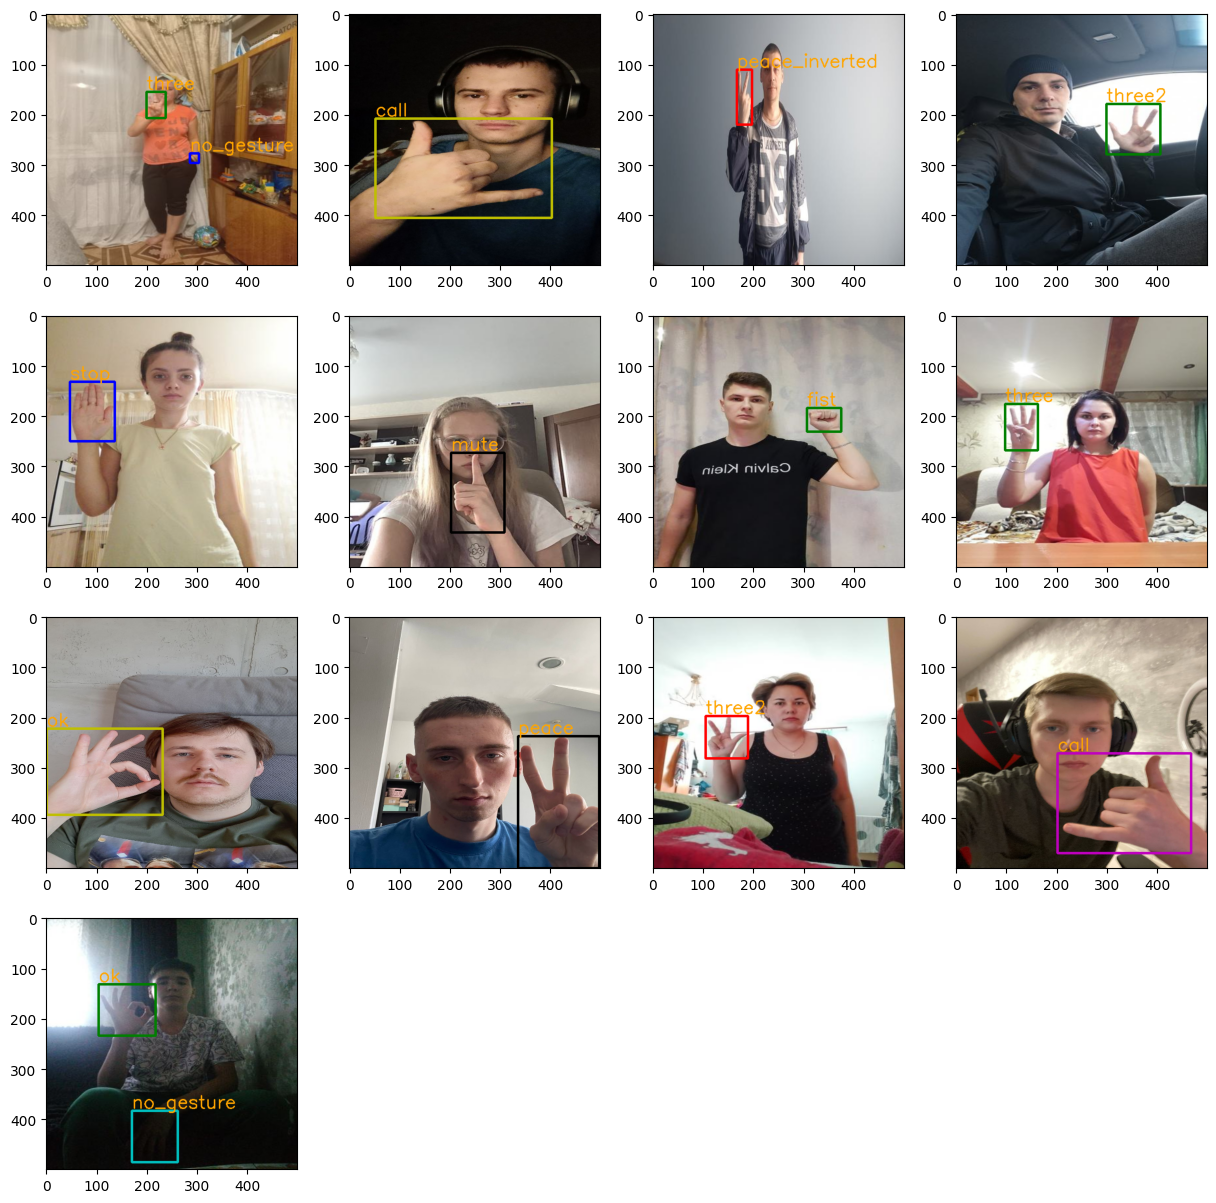

In [72]:
images_to_predict = random.sample(images, 13)
results = trained_model(images_to_predict)
draw_results(results, orig_size=False)